## Initialization

In [1]:
%cd ..
from base_algorithms import *
from sample_library import SampleLibrary
import numpy as np
from tqdm.contrib.concurrent import thread_map
from itertools import repeat
from population import Population
from population_logging import PopulationLogger

import librosa

c:\Users\justi\coding\Uni\MA


c:\Users\justi\miniconda3\envs\ma\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sample_lib = SampleLibrary()

Loading samples: 100%|██████████| 6478/6478 [00:10<00:00, 644.51it/s] 


## 1+1ES for single onset

In [25]:
#target_y, target_sr = librosa.load("./audio/EvoMix-NormalizedSamples/Normalized/Archive/SingleInstrumentSamples/ForMixing/AcousticGuitar/tr111AGAFM/tr111AGAFM01_E2.wav")
#target_stft = librosa.stft(target_y)
target_sample = sample_lib.get_random_sample_uniform()
print("Target: " + str(target_sample))
result = base_algorithm_1plus1_single_onset(target_sample.y, 10000, sample_lib)

Target: (DUNG_DKAR_TRUMPET_KEY, dung_dkar_trumpet, cis4)


 31%|███       | 3081/10000 [00:44<01:39, 69.39it/s, 																																																																																																				Best individual: [Onset: 0 | (DUNG_DKAR_TRUMPET_KEY, dung_dkar_trumpet, d4) | Fitness: inf], Fitness: 0.0] with fitness 0.0]                                                                                    


In [11]:
result = base_algorithm_1plus1_single_onset(target_sample.y, 10000, sample_lib)

 41%|████      | 4100/10000 [00:39<00:56, 104.16it/s, 																																																																																																				Best individual: (AcousticGuitar, tr112AGRFM, ais3) with fitness 0.0]                                                  


## 1+1ES for multiple onsets

In [4]:
test = BaseIndividual.create_multi_onset_individual(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), 0.5, sample_lib)
str(test)

'[(Cello, tr171VCNVM, f5), (Flute, tr332FLVIM, dis4), (Piano, tr011PFPEM, d6), (Flute, tr332FLVIM, cis6), (AcousticGuitar, tr113AGRPM, c3), (Trumpet, tr211TRVIM, d5)], [(Piano, tr012PFPM, fis6), (Violin, tr152VNNVM, d5)], [(Viola, tr161VLNVM, c5), (Violin, tr153VNNVM, e5), (AcousticGuitar, tr113AGRPM, dis3), (ElectricGuitar, tr132EGLPM, c5)], [(Viola, tr163VLNVM, ais3), (Piano, tr011PFPEM, ais4), (Flute, tr331FLNOM, g5), (Cello, tr173VCNOM, g2)]'

In [3]:
raw_y, _ = librosa.load("./audio/EvoMix-NormalizedSamples/Normalized/Archive/SingleInstrumentSamples/ForMixing/AcousticGuitar/tr111AGAFM/tr111AGAFM01_E2.wav")
target_y = np.append(raw_y, raw_y)

base_algorithm_1plus1_multi_offset(target_y, 1000, sample_lib, 1)

100%|██████████| 1000/1000 [00:26<00:00, 37.96it/s, 																																																																																																				Best individual: [(AcousticGuitar, tr112AGRFM, a3)], [(AcousticGuitar, tr112AGAFM, c5), (AcousticGuitar, tr111AGRFM, dis3)], [(Flute, tr332FLVIM, e6), (AcousticGuitar, tr112AGRFM, b3)] with fitness 2.161323678861789]                           


In [3]:
ex, _ = librosa.load(librosa.ex('nutcracker'), duration=15)
result = base_algorithm_1plus1_multi_offset(target_y=ex, max_steps=10000, sample_lib=sample_lib, onset_frac=1)

c:\Users\justi\miniconda3\envs\ma\lib\site-packages\librosa\core\spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=509
  warnings.warn(
100%|██████████| 10000/10000 [12:33<00:00, 13.27it/s, 																																																																																																				Best individual: [(ElectricGuitar, tr132EGVFM, cis4)], [(ElectricGuitar, tr133EGLFM, ais3)], [(Viola, tr162VLNOM, b5)], [(Cello, tr173VCNVM, gis2), (Viola, tr161VLSOM, fis3), (Cello, tr171VCSOM, d3)], [(Cello, tr171VCNVM, d3)], [(ElectricGuitar, tr131EGLFM, gis3)], [(Cello, tr171VCNVM, ais2), (Viola, tr163VLNOM, ais5)], [(Piano, tr012PFPM, f6), (Viola, tr163VLNOM, c4), (Flute, tr331FLVIM, fis4)], [(Viola, tr161VLSOM, b3)], [(Viola, tr162VLNVM, ais3)], [(Cello, tr171VCSOM, ais2)], [(Viola, tr162VLNOM, f4), (Viola, tr162VLNOM, ais3), (Cello, tr171VCSOM, g3)], [(Cello, tr171VCSOM, e2)], [(ElectricGuitar, tr132EGLPM, f3)], [(Viola, tr162VLNVM, c6)], [(Violin, tr151VNSOM, ais

In [6]:
ex_stft = librosa.stft(ex)
abs_stft = abs(ex_stft)
%timeit librosa.stft(ex)
%timeit np.abs(ex_stft)
%timeit np.average(abs_stft, axis=1)

9.17 ms ± 59.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.81 ms ± 50.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
76.4 µs ± 357 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [6]:
ex, _ = librosa.load(librosa.ex('nutcracker'), duration=15)
result = base_algorithm_1plus1_multi_offset(target_y=ex, max_steps=10000, sample_lib=sample_lib, onset_frac=1)

100%|██████████| 10000/10000 [08:26<00:00, 19.73it/s, 																																																																																																				Best individual: [(AcousticGuitar, tr112AGAFM, dis4), (Piano, tr011PFPEM, c5), (Piano, tr013PFNOM, e6)], [(AcousticGuitar, tr113AGAFM, f4), (Cello, tr172VCNOM, gis2)], [(ElectricGuitar, tr133EGLFM, e4), (Piano, tr011PFPEM, e4), (ElectricGuitar, tr132EGLPM, f2)], [(AcousticGuitar, tr111AGAPM, c3), (ElectricGuitar, tr132EGLPM, c5), (Cello, tr172VCNOM, a2), (Cello, tr172VCNVM, d4)], [(ElectricGuitar, tr132EGVFM, f4), (Flute, tr331FLNOM, fis5), (Piano, tr011PFNOM, a4), (ElectricGuitar, tr131EGLFM, e4)], [(Piano, tr013PFPEM, cis2)], [(AcousticGuitar, tr113AGAFM, gis3), (ElectricGuitar, tr132EGVFM, a2)], [(AcousticGuitar, tr113AGRFM, a2), (AcousticGuitar, tr113AGAPM, a4)], [(Piano, tr011PFNOM, f3), (AcousticGuitar, tr112AGAPM, ais3), (Cello, tr172VCNOM, e2)], [(AcousticGuitar, tr112AGAFM, e2), (ElectricGuitar, tr133EGLFM, gis2)], [(Piano, t

In [17]:
ex, _ = librosa.load(librosa.ex('nutcracker'), duration=30)
result = base_algorithm_1plus1_multi_offset(target_y=ex, max_steps=10000, sample_lib=sample_lib, onset_frac=.1)

100%|██████████| 10000/10000 [05:50<00:00, 28.54it/s, 																																																																																																				Best individual: [(AcousticGuitar, tr111AGRFM, gis4), (ElectricGuitar, tr131EGLFM, e3), (AcousticGuitar, tr112AGAFM, g3)], [(Viola, tr161VLSOM, fis3), (AcousticGuitar, tr112AGAFM, dis4), (AcousticGuitar, tr111AGRFM, g2), (AcousticGuitar, tr113AGAFM, dis3), (Cello, tr173VCNVM, gis2)], [(AcousticGuitar, tr112AGAFM, b3), (ElectricGuitar, tr131EGLFM, c3), (Cello, tr171VCSOM, d3), (AcousticGuitar, tr113AGRFM, f3)], [(AcousticGuitar, tr111AGRFM, b3), (AcousticGuitar, tr112AGAFM, cis3), (AcousticGuitar, tr112AGAPM, dis5), (AcousticGuitar, tr113AGRFM, ais3)], [(AcousticGuitar, tr111AGAPM, a4), (Viola, tr163VLNOM, fis5), (AcousticGuitar, tr112AGRFM, fis4), (Cello, tr173VCNOM, fis4), (AcousticGuitar, tr112AGAFM, g4)], [(AcousticGuitar, tr112AGAFM, dis4), (Flute, trflute.novib.mf, b5), (Piano, tr013PFNOM, dis6), (Cello, tr172VCNVM, dis2), (Cello

Performance profiling

In [4]:
ex, _ = librosa.load(librosa.ex('nutcracker'), duration=15)
%prun base_algorithm_1plus1_multi_offset(target_y=ex, max_steps=250, sample_lib=sample_lib, onset_frac=1)

c:\Users\justi\miniconda3\envs\ma\lib\site-packages\librosa\core\spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=510
  warnings.warn(
100%|██████████| 250/250 [00:14<00:00, 17.70it/s, 																																																																																																				Best individual: [(Trumpet, tr211TRVIM, b3), (Flute, trFltnvib, e5)], [(Flute, trflute.novib.mf, dis6), (Cello, tr171VCNOM, f3), (Piano, tr013PFPEM, b3)], [(Violin, tr152VNNOM, f5), (Violin, tr152VNNVM, gis4), (Piano, tr011PFPEM, a4)], [(Viola, tr161VLNOM, e3), (Cello, tr173VCNOM, cis4), (Piano, tr011PFPEM, f4)], [(AcousticGuitar, tr112AGRFM, dis3), (AcousticGuitar, tr111AGAPM, e5), (ElectricGuitar, tr131EGVFM, d4)], [(Piano, tr012PFPM, c4), (Viola, tr163VLNVM, d3), (Cello, tr172VCNOM, fis4)], [(AcousticGuitar, tr113AGAPM, gis4), (AcousticGuitar, tr111AGAPM, ais2), (AcousticGuitar, tr111AGRFM, e3)], [(Flute, tr332FLNOM, e5), (AcousticGuitar, tr111AGAPM, gis2), (Cello, tr172V

         2451628 function calls (2410171 primitive calls) in 14.425 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    26024    4.167    0.000    4.167    0.000 {built-in method numpy.array}
     1029    2.236    0.002    8.113    0.008 individual.py:15(calc_stft)
    10849    2.170    0.000    2.170    0.000 {built-in method numpy.fft._pocketfft_internal.execute}
     1059    1.635    0.002    4.783    0.005 spectrum.py:45(stft)
        1    1.162    1.162   14.416   14.416 base_algorithms.py:39(base_algorithm_1plus1_multi_offset)
    11543    0.784    0.000    0.784    0.000 {method 'reduce' of 'numpy.ufunc' objects}
     6211    0.141    0.000    0.250    0.000 arraypad.py:86(_pad_simple)
     4264    0.107    0.000    0.166    0.000 {method 'choice' of 'numpy.random.mtrand.RandomState' objects}
     6212    0.100    0.000    0.100    0.000 {built-in method numpy.empty}
   397482    0.081    0.000    0.113    0.000 util

Copy operation optimization

In [5]:
from copy import deepcopy
from individual import BaseIndividual
from mutations import Mutator
individual_1 = BaseIndividual.create_multi_onset_individual(np.array([0, 100]), 1, sample_lib)
mutator = Mutator(sample_lib)
print(individual_1)
temp_ind = deepcopy(individual_1)
individual_2 = mutator.mutate_individual(temp_ind)
print(individual_1)
print(individual_2)

[(ElectricGuitar, tr131EGLFM, c4), (Violin, tr151VNNVM, fis6), (Viola, tr163VLNVM, fis4)], [(AcousticGuitar, tr111AGRPM, c5), (Cello, tr171VCNOM, b2), (Flute, tr332FLVIM, fis6), (AcousticGuitar, tr113AGAPM, b4)]
[(ElectricGuitar, tr131EGLFM, c4), (Violin, tr151VNNVM, fis6), (Viola, tr163VLNVM, fis4)], [(AcousticGuitar, tr111AGRPM, c5), (Cello, tr171VCNOM, b2), (Flute, tr332FLVIM, fis6), (AcousticGuitar, tr113AGAPM, b4)]
[(ElectricGuitar, tr131EGLFM, c4), (Violin, tr151VNNVM, fis6), (Viola, tr163VLNVM, fis4), (Violin, tr153VNNVM, ais3)], [(AcousticGuitar, tr111AGRPM, c5), (Cello, tr171VCNOM, b2), (Flute, tr332FLVIM, fis6), (AcousticGuitar, tr113AGAPM, d5)]


In [6]:
from individual import SampleCollection
individual_1 = BaseIndividual.create_multi_onset_individual(np.array([0, 100]), 1, sample_lib)
sample_1 = individual_1.sample_collections[0]
sample_2 = SampleCollection.from_copy(sample_1)
print(sample_1)
print(sample_2)
mutator.mutate_pitch(sample_2)
print(sample_1)
print(sample_2)

(Cello, tr173VCNVM, e4), (Flute, tr332FLVIM, f4), (Flute, tr332FLNOM, e4)
(Cello, tr173VCNVM, e4), (Flute, tr332FLVIM, f4), (Flute, tr332FLNOM, e4)
(Cello, tr173VCNVM, e4), (Flute, tr332FLVIM, f4), (Flute, tr332FLNOM, e4)
(Cello, tr173VCNVM, e4), (Flute, tr332FLVIM, a4), (Flute, tr332FLNOM, e4)


In [9]:
from individual import SampleCollection
individual_1 = BaseIndividual.create_multi_onset_individual(np.array([0, 100]), 1, sample_lib)
individual_2 = BaseIndividual.from_copy(individual_1)
print(individual_1)
print(individual_2)
mutator.mutate_individual(individual_2)
print(individual_1)
print(individual_2)

[(Cello, tr171VCNOM, g4), (Cello, tr172VCNVM, dis5)], [(Violin, tr153VNNVM, e6), (Violin, tr152VNNVM, a5)]
[(Cello, tr171VCNOM, g4), (Cello, tr172VCNVM, dis5)], [(Violin, tr153VNNVM, e6), (Violin, tr152VNNVM, a5)]
[(Cello, tr171VCNOM, g4), (Cello, tr172VCNVM, dis5)], [(Violin, tr153VNNVM, e6), (Violin, tr152VNNVM, a5)]
[(Cello, tr171VCNVM, f2), (Cello, tr172VCNVM, dis5), (Trumpet, tr211TRNOM, a5)], [(Violin, tr152VNNOM, a5), (Trumpet, trCTpt, a3)]


In [10]:
%timeit deepcopy(individual_1)
%timeit BaseIndividual.from_copy(individual_1)

194 µs ± 2.19 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
19.8 µs ± 87.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


# Full Population Testing

In [8]:
MAX_STEPS = 10000
ONSET_FRAC = 0.1
POPSIZE = 400
N_OFFSPRING = 1

In [3]:
ex, _ = librosa.load(librosa.ex('nutcracker'), duration=30)
result = approximate_piece(target_y=ex, max_steps=MAX_STEPS, sample_lib=sample_lib, onset_frac=ONSET_FRAC, popsize=POPSIZE, n_offspring=N_OFFSPRING)

100%|██████████| 3000/3000 [01:19<00:00, 37.73it/s, 																																																																																																				Best individual: [Onset: 62976 | (AcousticGuitar, tr113AGAFM, ais3), (MELODICA_KEY, melodica, d5) | Fitness: 7.18200790777439], [Onset: 621056 | (Viola, tr163VLNVM, gis5), (TURKEY_SAZ, turkey_saz, g4), (Clarinet, Clarinet_Essential, d4) | Fitness: 5.423022103658536], [Onset: 175616 | (Trombone, BassTrombone_SessionHornsPro, d1), (Violin, tr153VNNOM, dis5), (Piano, tr011PFPEM, g5), (AcousticGuitar, tr113AGAFM, d4), (Bassoon, Bassoons_Essential, cis5) | Fitness: 14.211370045731707], [Onset: 472576 | (ElectricPiano, Scarbee_Clavinet_Full_DI, a3), (CUMBUS_OPEN_STRINGS, cumbus, b4), (TURKEY_SAZ, turkey_saz, e5) | Fitness: 7.226913109756097], [Onset: 603136 | (Saxophone, AltoSax_SessionHornsPro, ais3), (Viola, Violas_SessionStringsPro, ais5), (ElectricGuitar, tr131EGLFM, dis4) | Fitness: 9.32578887195122], [Onset: 330752 | (MORIN_KHUUR_VIOLIN

In [9]:
ex, _ = librosa.load(librosa.ex('nutcracker'), duration=30)
result = approximate_piece(target_y=ex, max_steps=MAX_STEPS, sample_lib=sample_lib, onset_frac=ONSET_FRAC, popsize=POPSIZE, n_offspring=N_OFFSPRING)

100%|██████████| 30000/30000 [13:41<00:00, 36.54it/s, 																																																																																																				Best individual: [Onset: 318976 | (Piano, The_Gentleman, f7), (Piano, The_Gentleman, d4), (AcousticGuitar, tr112AGAFM, gis2), (BANJO_FRAMUS, banjo_framus, dis5) | Fitness: 2.8275564500762194], [Onset: 614912 | (AcousticGuitar, tr112AGAFM, gis2), (TURKEY_SAZ, turkey_saz, fis4), (AcousticGuitar, tr113AGRFM, g4), (SHAKUHACHI_KEY, shakuhachi, b3) | Fitness: 1.4497013147865854], [Onset: 594432 | (AcousticGuitar, tr111AGRPM, cis3), (Bass, Basses_Essential, cis4), (PINKILLO_KEY, pinkillo, g5), (BANJO_FRAMUS, banjo_framus, ais2) | Fitness: 3.7699666539634147], [Onset: 125952 | (AcousticGuitar, tr111AGRFM, d5) | Fitness: 2.104592225609756], [Onset: 163328 | (AcousticGuitar, tr111AGRFM, e2) | Fitness: 3.8078125], [Onset: 259584 | (Cello, tr171VCNOM, f4), (ElectricGuitar, tr132EGVFM, dis4), (AcousticGuitar, tr111AGAFM, fis4) | Fitness: 2.9914062

In [9]:
# Logging test
ex, _ = librosa.load(librosa.ex('nutcracker'), duration=30)
logger = PopulationLogger()
result = approximate_piece(target_y=ex, max_steps=MAX_STEPS, sample_lib=sample_lib, onset_frac=ONSET_FRAC, popsize=POPSIZE, n_offspring=N_OFFSPRING, logger=logger)

100%|██████████| 10000/10000 [05:12<00:00, 32.04it/s, 																																																																																																				Best individual: [Onset: 301568 | (OUD, oud, dis3), (Viola, tr163VLNVM, e3), (AcousticGuitar, tr112AGAFM, gis2), (Contrabassoon, Contrabassoon_Essential, ais3) | Fitness: 3.639306164253049], [Onset: 295424 | (AcousticGuitar, tr111AGAPM, cis5), (Viola, tr161VLSOM, ais3), (Trumpet, Trumpets_Essential, cis3), (AcousticGuitar, tr111AGAPM, e5) | Fitness: 4.828129287347561], [Onset: 307200 | (AcousticGuitar, tr111AGAPM, d5), (Piano, Alicias_Keys, g1), (Trumpet, tr211TRVIM, d4) | Fitness: 5.361230945121951], [Onset: 138240 | (ElectricPiano, Scarbee_Pianet_DI, ais4), (Piano, tr011PFNOM, fis5) | Fitness: 5.6667911585365855], [Onset: 621056 | (Cello, Cellos_Essential, d2), (Flute, tr331FLNOM, e5), (PINKILLO_KEY, pinkillo, dis5) | Fitness: 2.0832369474085364], [Onset: 236032 | (Piano, tr011PFPEM, e3), (Piano, tr012PFPM, fis4), (AcousticGuitar, t

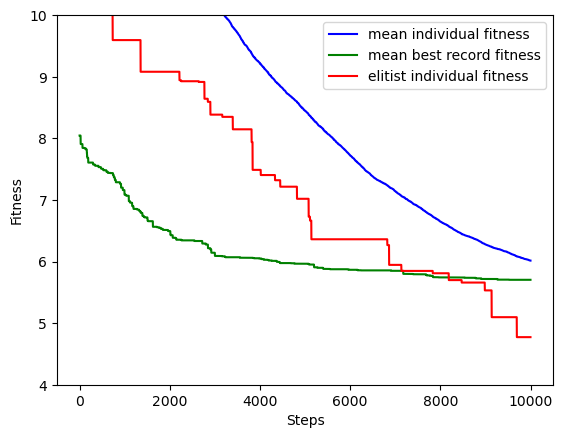

In [22]:
import matplotlib.pyplot as plt
plt.plot(logger.logged_steps, logger.mean_fitness, "b", label="mean individual fitness")
plt.plot(logger.logged_steps, logger.mean_fitness_best_records, "g", label="mean best record fitness")
plt.plot(logger.logged_steps, logger.elitist_fitness, "r", label="elitist individual fitness")
plt.xlabel("Steps")
plt.ylabel("Fitness")
plt.ylim((4, 10))
plt.legend()


In [18]:
share = [collection for collection in result.get_best_individual().sample_collections.values() if collection == result.best_collections_per_onset[collection.onset]]
len(share)
distances = [collection.fitness - result.best_collections_per_onset[collection.onset].fitness for collection in result.get_best_individual().sample_collections.values()]
distances

[0.3388488471798783,
 0.7047827743902442,
 3.3165158155487804,
 3.9930766482469515,
 1.0116134717987804,
 3.2051209984756097,
 3.4653670445884144]

In [10]:
print("\n".join([str(collection) for collection in result.best_collections_per_onset.values()])) # g = 30000

Onset: 212480 | (AcousticGuitar, tr113AGRFM, ais3), (FUJARA_KEY, fujara, dis4), (AcousticGuitar, tr113AGAFM, g2) | Fitness: 1.7776495807926829
Onset: 259584 | (ElectricBass, Scarbee_Rickenbacker_Bass_Crunsher, fis3), (AcousticGuitar, tr111AGRFM, fis4), (Bassoon, Bassoons_Essential, g2) | Fitness: 1.6483517530487806
Onset: 414720 | (AcousticGuitar, tr111AGAPM, cis5), (ElectricPiano, Scarbee_A200_WheresWallee, e3), (Viola, tr162VLNOM, dis3) | Fitness: 2.1652405678353657
Onset: 372224 | (AcousticGuitar, tr112AGRFM, a3), (PINKILLO_KEY, pinkillo, d5), (DALLAPE_ACCORDION_KEY, dallape_accordion, d2), (PANFLUTE_KEY, panflute, a2) | Fitness: 17.39076219512195
Onset: 566784 | (AcousticGuitar, tr113AGAFM, g2), (ElectricBass, Scarbee_JayBass_Slap_Neck, g3), (Trombone, BassTrombone_SessionHornsPro, gis1) | Fitness: 2.794596512957317
Onset: 342528 | (Flute, tr331FLVIM, cis4), (Flute, trFltnvib, a4) | Fitness: 8.320756478658536
Onset: 366080 | (Bassoon, Bassoons_Essential, dis3), (Flute, tr332FLNOM, 

In [7]:
print("\n".join([str(collection) for collection in result.best_collections_per_onset.values()])) # g = 3000

Onset: 372224 | (Trumpet, tr211TRVIM, e3), (Violin, Violins_SessionStringsPro, c7) | Fitness: 18.096575838414633
Onset: 490496 | (AcousticGuitar, tr112AGRPM, e2), (SITAR_KEY, sitar, gis4), (Violin, tr152VNNVM, a4) | Fitness: 8.062132240853659
Onset: 62976 | (Piano, tr011PFNOM, dis5), (AcousticGuitar, tr113AGAFM, cis4) | Fitness: 2.854128239329268
Onset: 460800 | (AcousticGuitar, tr112AGAFM, gis3), (Piano, The_Giant_soft, dis7), (SHAKUHACHI_KEY, shakuhachi, cis5) | Fitness: 3.379405011432927
Onset: 614912 | (MORIN_KHUUR_VIOLIN_KEY, morin_khuur_violin, b4), (AcousticGuitar, tr112AGRPM, g3), (DUNG_DKAR_TRUMPET_KEY, dung_dkar_trumpet, c5) | Fitness: 2.8543564214939026
Onset: 519680 | (CEYLON_GUITAR, ceylon_guitar, d2), (Violin, tr152VNNOM, a5), (Flute, trflute.novib.mf, dis5), (BOUZOUKI_SAKIS_KEY, boizouki, ais4), (KANTELE_LOW_WIDE_RANGE, kantele, dis5) | Fitness: 8.205895579268292
Onset: 236032 | (ERHU_KEY, erhu_key, ais4), (Flute, tr332FLNOM, d6), (Flute, trFltnvib, d4), (UKULELE_KEY, uk

In [11]:
result.save_as_file("30k_gen_nutcracker.pkl")

In [2]:
loaded = Population.from_file("test.pkl")

Multithreading POC

In [21]:
def single_step(population:Population, n_offspring:int, target:Target, mutator:Mutator):
    # Create lambda offspring
    parents = np.random.choice(len(population.individuals), size=n_offspring)
    offspring = [mutator.mutate_individual(BaseIndividual.from_copy(population.individuals[individual_idx])) for individual_idx in parents]
    
    # Evaluate fitness of offspring
    for individual in offspring:
        individual.fitness = multi_onset_fitness_cached(target, individual)
        # Insert individual into population
        population.insert_individual(individual)
    
    # Remove lambda worst individuals
    population.remove_worst(n_offspring)

    # Update progress bar
    #pbar.set_postfix_str('\t' * 100 + f"Best individual: {str(population.get_best_individual())}")

def approximate_piece_multithreaded(target_y:Union[np.ndarray, list], max_steps:int, sample_lib:SampleLibrary, popsize:int, n_offspring:int, onset_frac:float, n_threads:int) -> Population:
    """Evolutionary approximation of a polyphonic musical piece

    Parameters
    ----------
    target_y : Union[np.ndarray, list]
        signal of the target musical piece, as imported by librosa
    max_steps : int
        Maximum number of iterations (generations) before termination
    sample_lib : SampleLibrary
        Library of samples which define the algorithm's search space
    popsize : int
        Size of the population (µ)
    n_offspring : int
        Number of offspring (λ) per generation 
    onset_frac : float
        Fraction of approximated onsets (φ) per individual

    Returns
    -------
    Population
        The full population of individual approximations after max_steps of iterations
    """
    # Initialization
    mutator = Mutator(sample_lib) # Applies mutations and handles stft updates
    target = Target(target_y)

    # Create initial population
    population = Population()
    population.individuals = [BaseIndividual.create_multi_onset_individual(target.onsets, onset_frac, sample_lib) for _ in tqdm(range(popsize), desc="Initializing Population")]
    def fitness_init(individual):
        individual.fitness = multi_onset_fitness_cached(target, individual)
    thread_map(fitness_init, population.individuals, max_workers=n_threads, desc="Calculating initial fitness")
    # for individual in tqdm(population.individuals, desc="Calculating initial fitness"):
    #     # Calc initial fitness
    #     individual.fitness = multi_onset_fitness_cached(target, individual)
    population.calc_best_fitnesses_per_onset() # Initial record of best approximations of each onset
    population.sort_individuals_by_fitness() # Sort population for easier management

    # Evolutionary Loop
    thread_map(single_step, repeat(population, max_steps), repeat(n_offspring, max_steps), repeat(target, max_steps), repeat(mutator, max_steps), max_workers=n_threads, chunksize=1)
    # for step in (pbar := tqdm(range(max_steps))):
    #     # Create lambda offspring
    #     parents = np.random.choice(population.individuals, size=n_offspring)
    #     offspring = [mutator.mutate_individual(BaseIndividual.from_copy(individual)) for individual in parents]
        
    #     # Evaluate fitness of offspring
    #     for individual in offspring:
    #         individual.fitness = multi_onset_fitness_cached(target, individual)
    #         # Insert individual into population
    #         population.insert_individual(individual)
        
    #     # Remove lambda worst individuals
    #     population.remove_worst(n_offspring)

    #     # Update progress bar
    #     pbar.set_postfix_str('\t' * 100 + f"Best individual: {str(population.get_best_individual())}")

    # Return final population
    return population
ex, _ = librosa.load(librosa.ex('nutcracker'), duration=30)
result = approximate_piece_multithreaded(ex, MAX_STEPS, sample_lib, POPSIZE, N_OFFSPRING, ONSET_FRAC, n_threads=4)

100%|██████████| 30000/30000 [06:44<00:00, 74.10it/s] 


Notes: The threaded implementation leads to incorrect results as of right now, with n_threads multiples of some individuals within the final pop.

## Multiprocessing with subpopulations